# Detection of Labels on Palletized Inventory

Given two test images as examples we construct a computer vision pipeline to detect the position (u,v), orientation (theta), perimeter (p), area (A), and confidence (mu) of label detections.

## Import dependencies, Define helper functions

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob


DEBUG_LEVEL = 0
def debug_plot(img, priority=0, cvtmode=None, title=None, figsize=None):
    if priority >= DEBUG_LEVEL:
        plt.figure(figsize=figsize);
        if cvtmode is not None:
            img = cv2.cvtColor(img, cvtmode)
        plt.imshow(img, cmap='gray');
        if title is not None:
            plt.title(title)

## Run Label Detection pipeline on each test image with optional rotation

h= 250  w= 444
255 0
h= 250  w= 375
255 0


//anaconda/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


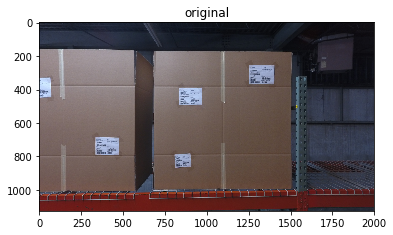

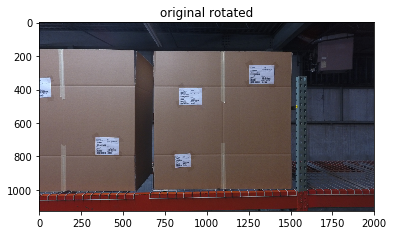

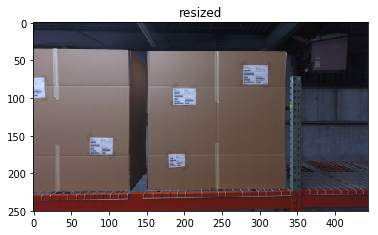

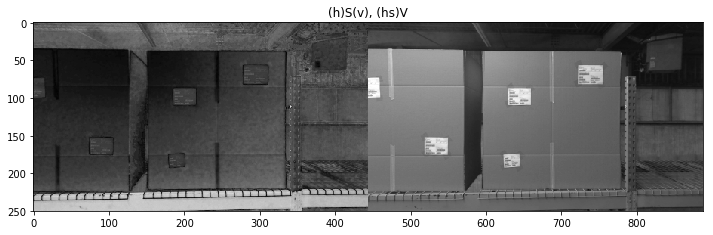

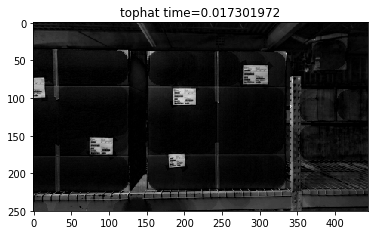

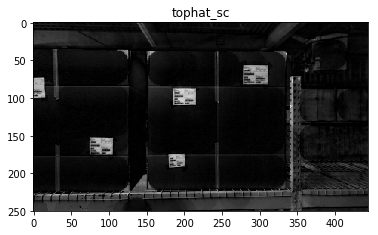

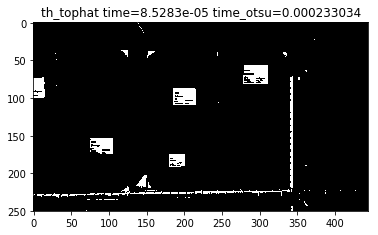

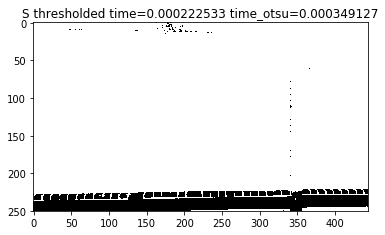

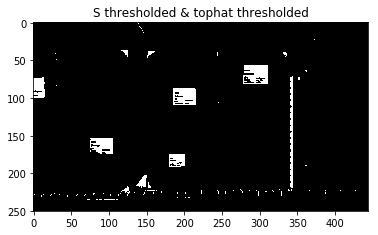

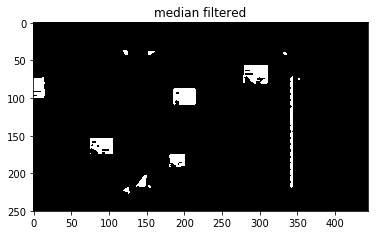

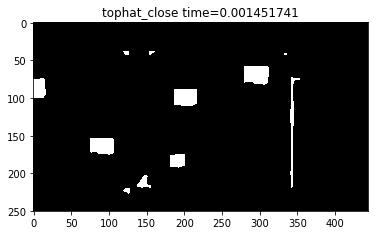

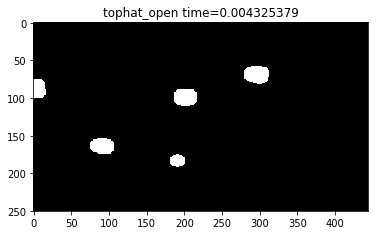

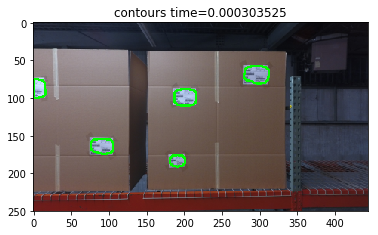

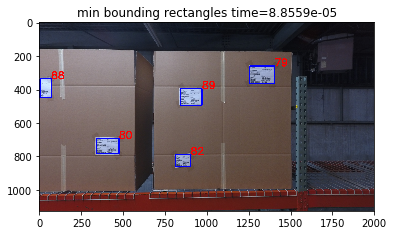

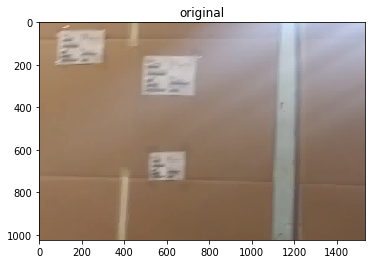

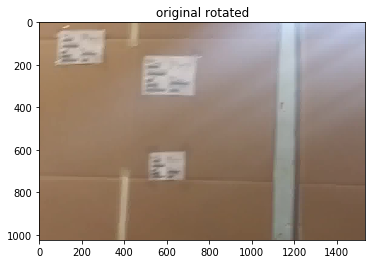

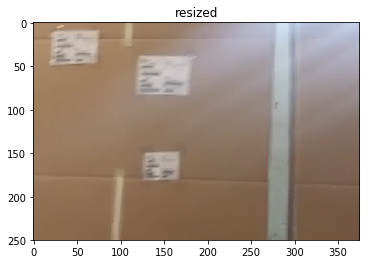

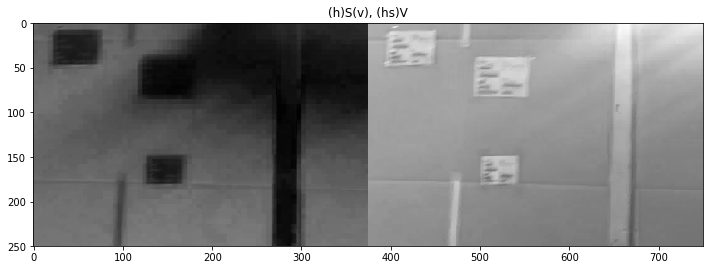

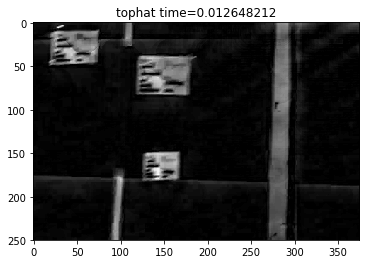

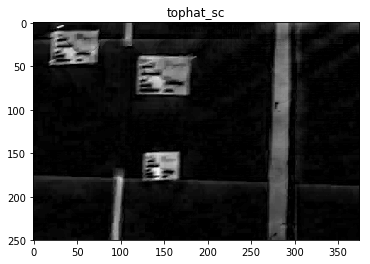

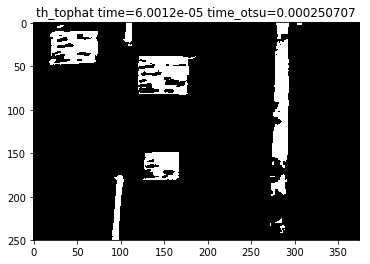

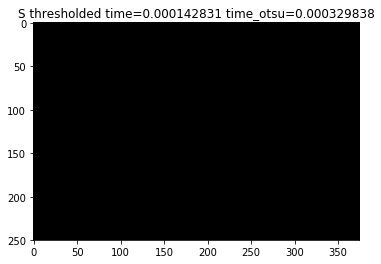

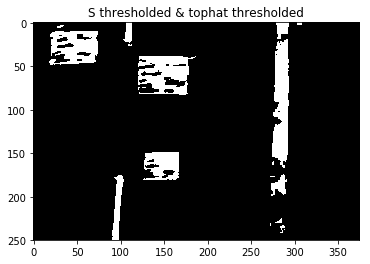

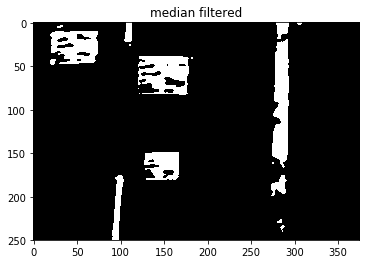

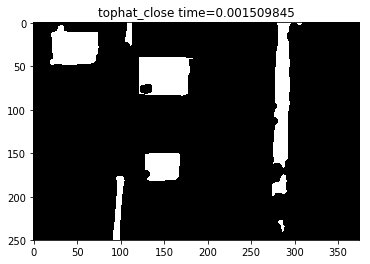

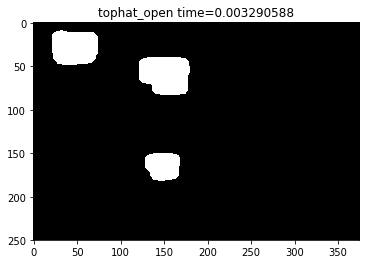

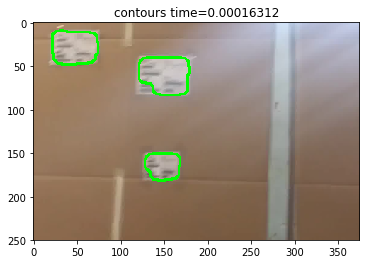

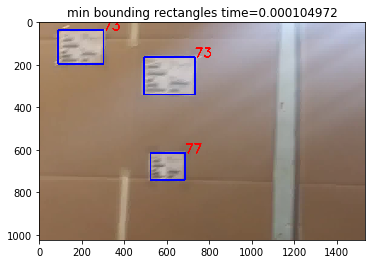

In [5]:
examplefiles = glob.glob('../data/*.jpg')
# for profiling
tick_freq = cv2.getTickFrequency()

plt.close('all')
for examplefile in examplefiles:
    
    # Load a test image
    img_orig = mpimg.imread(examplefile)
    debug_plot(img_orig, title='original')
    
    # Rotate it to test for rotational invariance
    rows,cols = img_orig.shape[:2] 
    M = cv2.getRotationMatrix2D((cols/2,rows/2),0,1)
    img_orig = cv2.warpAffine(img_orig,M,(cols,rows))
    debug_plot(img_orig, title='original rotated')
    
    # Resize to save computation, preserving aspect ratio
    orig_height, orig_width = img_orig.shape[:2]
    new_height = 250
    new_width = round(new_height/orig_height*orig_width)
    print('h=',new_height,' w=',new_width)
    img = cv2.resize(img_orig,(new_width, new_height), interpolation = cv2.INTER_AREA)
    debug_plot(img, title='resized')
    
    # Get V channel image from HSV color space
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    debug_plot(np.hstack((img_hsv[:,:,1],img_hsv[:,:,2])), title='(h)S(v), (hs)V', figsize=(12,6))

    # Subtract background estimate using morphological tophat operation:
    # 1) estimate background using morph open
    # 2) subtract background estimate
    e0 = cv2.getTickCount()
    img_tophat = cv2.morphologyEx(img_hsv[:,:,2], cv2.MORPH_TOPHAT,
                                  cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(round(new_height*0.125)),
                                                                             int(round(new_height*0.125)))))#(125,125)))
    e1 = cv2.getTickCount()
    debug_plot(img_tophat, title='tophat time={}'.format((e1-e0)/tick_freq))
    
#     # Blur image
#     img_tophat_blur = cv2.GaussianBlur(img_tophat, (3,3) , 0)
#     debug_plot(img_tophat_blur, title='tophat_blur')
    
    # Shift minimum to zero, then scale for maximum value to be 255
#     img_tophat_sc = img_tophat - np.min(np.min(img_tophat))
#     img_tophat_sc = np.uint8(img_tophat_sc/np.max(np.max(img_tophat_sc))*255)
    img_tophat_sc = np.zeros_like(img_tophat)
    cv2.normalize(img_tophat, img_tophat_sc, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    print(img_tophat_sc.max(), img_tophat_sc.min())
    debug_plot(img_tophat_sc, title='tophat_sc')
    
    # Threshold background suppressed image
    e0 = cv2.getTickCount()
    img_th_tophat = cv2.threshold(img_tophat_sc, 90, 255, cv2.THRESH_BINARY)[1]
    e1 = cv2.getTickCount()
    img_th_tophat_otsu = cv2.threshold(img_tophat, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    e2 = cv2.getTickCount()
    time = (e2 - e1)/ cv2.getTickFrequency()
    debug_plot(img_th_tophat, title='th_tophat time={} time_otsu={}'.format((e1-e0)/tick_freq, (e2-e1)/tick_freq))
    
    # Threshold S channel
    e0 = cv2.getTickCount()
    img_s_th = cv2.threshold(img_hsv[:,:,1], 130, 255, cv2.THRESH_BINARY_INV)[1]
    e1 = cv2.getTickCount()
    img_s_th_otsu = cv2.threshold(img_hsv[:,:,1], 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
    e2 = cv2.getTickCount()
    debug_plot(img_s_th, title='S thresholded time={} time_otsu={}'.format((e1-e0)/tick_freq, (e2-e1)/tick_freq))
    
    # Combine binary images
    img_binary = img_s_th&img_th_tophat
    debug_plot(img_binary, title='S thresholded & tophat thresholded')
    
    # Apply median filter
    median_kernel = int(round(new_height*0.01))
    median_kernel += median_kernel % 2 == 0
    img_median = cv2.medianBlur(img_binary, median_kernel)#int(round(new_height*0.01)))
    debug_plot(img_median, title='median filtered')
    
    # Apply morph close operation to fill in holes in label masks
    e0 = cv2.getTickCount()
    img_tophat_close = cv2.morphologyEx(img_median, cv2.MORPH_CLOSE,
                                      cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(round(new_height*0.040)),
                                                                                 int(round(new_height*0.040)))),#(40,40)),
                                      iterations=1)
    e1 = cv2.getTickCount()
    debug_plot(img_tophat_close, title='tophat_close time={}'.format((e1-e0)/tick_freq), priority=1)
    
    # Apply morph open operation to eliminate (hopefully) non-label spurious white pixels
    e0 = cv2.getTickCount()
    img_tophat_open = cv2.morphologyEx(img_tophat_close, cv2.MORPH_OPEN,
                                    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(round(new_height*0.075)),
                                                                               int(round(new_height*0.060)))),#(80,60) maybe (70,60)
                                     iterations=1)
    e1 = cv2.getTickCount()
    debug_plot(img_tophat_open, title='tophat_open time={}'.format((e1-e0)/tick_freq), priority=1)
    
    # Find Contours in the cleaned up binary image
    e0 = cv2.getTickCount()
    im2, contours, hierarchy = cv2.findContours(img_tophat_open,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    e1 = cv2.getTickCount()
    img_contours = img.copy()
    cv2.drawContours(img_contours, contours, -1, (0,255,0), 2)
    debug_plot(img_contours, title='contours time={}'.format((e1-e0)/tick_freq), priority=1)
    
    # Find Minimum Bounding Rectangle for each contour
    img_rectangles = img_orig.copy()
    tick_count = 0
    for cnt in contours:
        e0 = cv2.getTickCount()
        rect = cv2.minAreaRect(cnt)
        e1 = cv2.getTickCount()
        tick_count += e1 - e0
        box = cv2.boxPoints(rect)
        min_x = int(box[:,0].min())
        min_y = int(box[:,1].min())
        max_x = int(box[:,0].max())
        max_y = int(box[:,1].max())
        
        # TODO: Change this to account for rotated rectangles
        num_hot = cv2.countNonZero(img_binary[min_y:max_y,min_x:max_x])
        # TODO: Incorporate penalty for hot pixels surrounding rectangle
#         num_hot_border = np.count_nonzero(img_binary[min_x-:max_x,min_y:max_y])
        total = (max_x - min_x)*(max_y - min_y)
        confidence = float(num_hot)/float(total)*100
        box[:,0] *= orig_width/new_width
        box[:,1] *= orig_height/new_height
        box = np.int0(np.round(box))
        cv2.drawContours(img_rectangles,[box],0,(0,0,255),6)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img_rectangles, str(round(confidence)), (int(box[:,0].max()), int(box[:,1].min())),
                    font, 2, (255,0,0), 6, cv2.LINE_AA)
        
    debug_plot(img_rectangles, title='min bounding rectangles time={}'.format(tick_count/tick_freq), priority=2)

plt.show()